# Facial Keypoints Detection
- Jan Burian
- https://www.kaggle.com/competitions/facial-keypoints-detection/overview

## Modules import

In [1]:
import numpy as np
from pathlib import Path 
import os
import math
import pandas as pd
import json 
import matplotlib.pyplot as plt
from PIL import Image

import wandb

from sklearn.model_selection import train_test_split 
from sklearn.impute import KNNImputer

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from albumentations.pytorch import ToTensorV2
import albumentations as A

from datetime import datetime
import random

In [2]:
!pip install seaborn
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


## Preparing data

In [3]:
data_directory = Path('./data/facial-keypoints-detection')
BASE_directory = os.path.join(os.getcwd(), data_directory)
!pwd # current working directory
print(BASE_directory)

/auto/brno2/home/jburian/ondemand
/auto/brno2/home/jburian/ondemand/data/facial-keypoints-detection


In [4]:
# Training data
train_csv = pd.read_csv(os.path.join(BASE_directory, 'training', 'training.csv'))
train_csv.T # Transposed for better visualization

,0,1,2,3,4,5,6,7,8,9,...,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301,69.680748,64.131866,67.468893,65.80288,64.121231,...,69.229935,63.352951,65.711151,67.929319,66.867222,67.402546,66.1344,66.690732,70.965082,66.938311
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261,39.968748,34.29004,39.413452,34.7552,36.740308,...,38.575634,35.671311,38.843545,35.846552,37.356855,31.842551,38.365501,36.845221,39.853666,43.42451
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481,29.183551,29.578953,29.355961,27.47584,29.468923,...,29.407912,33.952078,32.268751,28.68782,30.750926,29.746749,30.478626,31.66642,30.543285,31.096059
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032,37.563364,33.13804,39.621717,36.1856,38.390154,...,38.34545,40.816448,37.706043,41.452484,40.115743,38.632942,39.950198,39.685042,40.772339,39.528604
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589,62.864299,57.797154,59.554951,58.65216,58.620923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261,40.169271,35.15404,40.454773,37.32928,37.840615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926,76.898243,69.026577,75.591612,72.95296,71.272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466,41.171888,34.29004,40.038245,35.89952,37.290338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238,36.401047,34.761664,37.478214,36.3424,36.344615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852,39.367626,33.71404,40.454773,37.0432,39.490462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Test data
test_csv = pd.read_csv(os.path.join(BASE_directory, 'test', 'test.csv'))
test_csv.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


## Training data visualization

In [6]:
# Function to plot image with keypoints
def plot_image_with_keypoints(ax, image_data, keypoints, idx):
    img = np.array(image_data['Image'].split(), dtype='uint8')
    img = img.reshape((96, 96))

    # Plot the image
    ax.imshow(img, cmap='gray')

    # Plot keypoints and lines with text annotations
    for i in range(0, len(keypoints), 2):
        x, y = keypoints[i], keypoints[i + 1]

        # Plot keypoint
        ax.scatter(x, y, color='red', marker='+')

#         # Connect keypoint with a line
#         ax.plot([x, x], [y, y], color='blue', linestyle='--')

#         # Add text label at the end of the line
#         label = f"({x}, {y})"
#         ax.text(x, y, label, color='blue', fontsize=8, ha='right', va='bottom')

    ax.set_title(f"Image ID: {idx}")
    ax.axis('off')
    
def visualize_image_data(number_of_images, data: pd, idx: int, axes):
    image_data = data.iloc[idx]
    keypoints = image_data[:-1]  # Exclude the last column (Image)
    plot_image_with_keypoints(axes[i], image_data, keypoints, idx)

Text(0.5, 0.98, 'Images with keypoints')

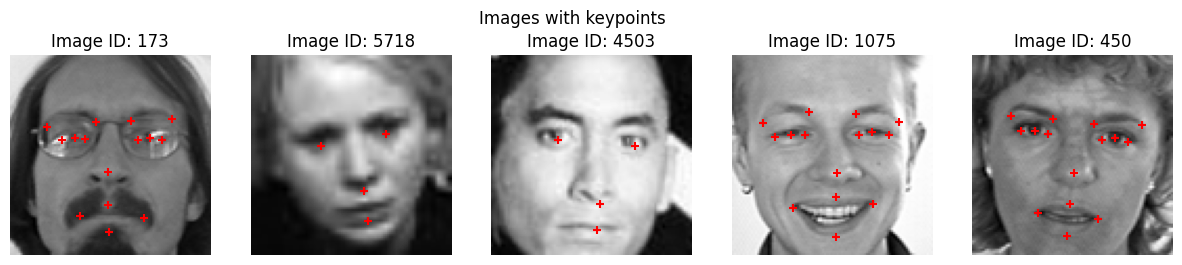

In [7]:
num_images = 5 # number of images to be visualized with keypoints
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i in range(num_images):
    idx = random.randint(0,len(train_csv))
    visualize_image_data(num_images, train_csv, idx, axes)
fig.suptitle("Images with keypoints")

## Data statistics

In [8]:
def get_keypoint_count_dictionary(data: pd):
    keypoint_count_dictionary = {}

    for keypoint_name in data.columns:
        if keypoint_name == "Image":
            continue

        keypoint_data = data[keypoint_name]

        # Check for non-numeric values and NaN
        valid_keypoint_data = keypoint_data[pd.to_numeric(keypoint_data, errors='coerce').notna()]

        # Count the number of valid values
        num_valid_keypoint_data = len(valid_keypoint_data)

        # Store the count in the dictionary with the keypoint name as the key
        keypoint_count_dictionary[keypoint_name] = num_valid_keypoint_data
    
    return keypoint_count_dictionary

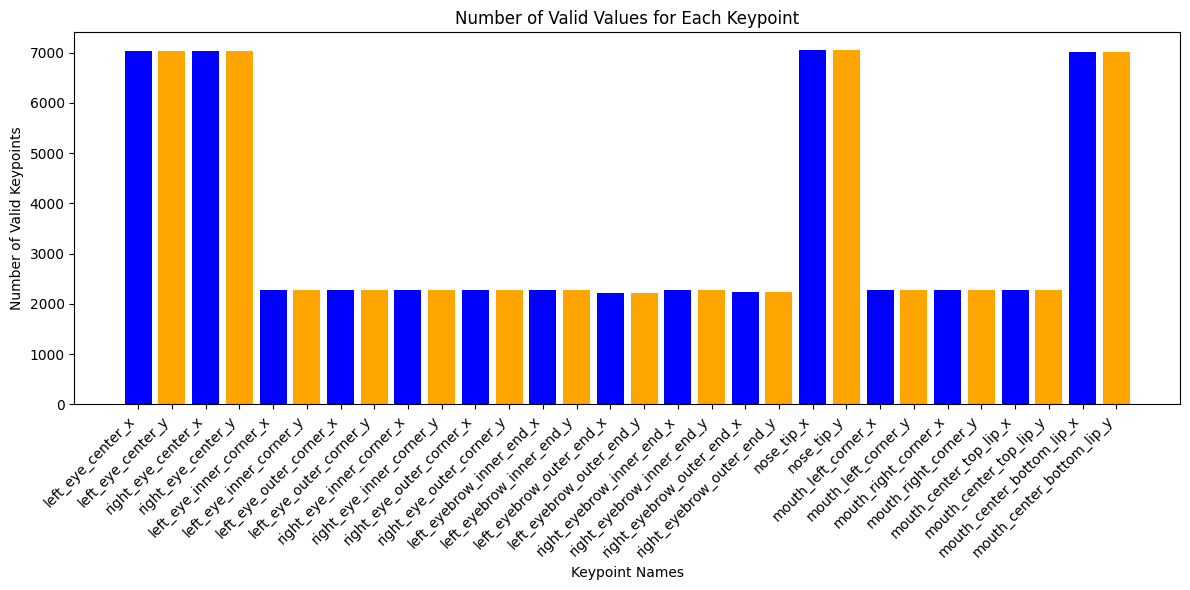

Number of x and y keypoints coordinates: 30.


In [9]:
def visualize_num_valid_keypoints(keypoint_count_dictionary: dict):
    # Extract keypoint names and corresponding counts
    keypoint_names = list(keypoint_count_dictionary.keys())
    keypoint_counts = list(keypoint_count_dictionary.values())

    # Create a list of colors for neighboring bars
    bar_colors = ['blue' if i % 2 == 0 else 'orange' for i in range(len(keypoint_names))]

    # Create a histogram with alternating colors for neighboring bars
    plt.figure(figsize=(12, 6))
    bars = plt.bar(keypoint_names, keypoint_counts, color=bar_colors)
    plt.xlabel('Keypoint Names')
    plt.ylabel('Number of Valid Keypoints')
    plt.title('Number of Valid Values for Each Keypoint')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
keypoint_count_dictionary = get_keypoint_count_dictionary(train_csv)
visualize_num_valid_keypoints(keypoint_count_dictionary)
print(f"Number of x and y keypoints coordinates: {len(keypoint_count_dictionary)}.")

<Axes: >

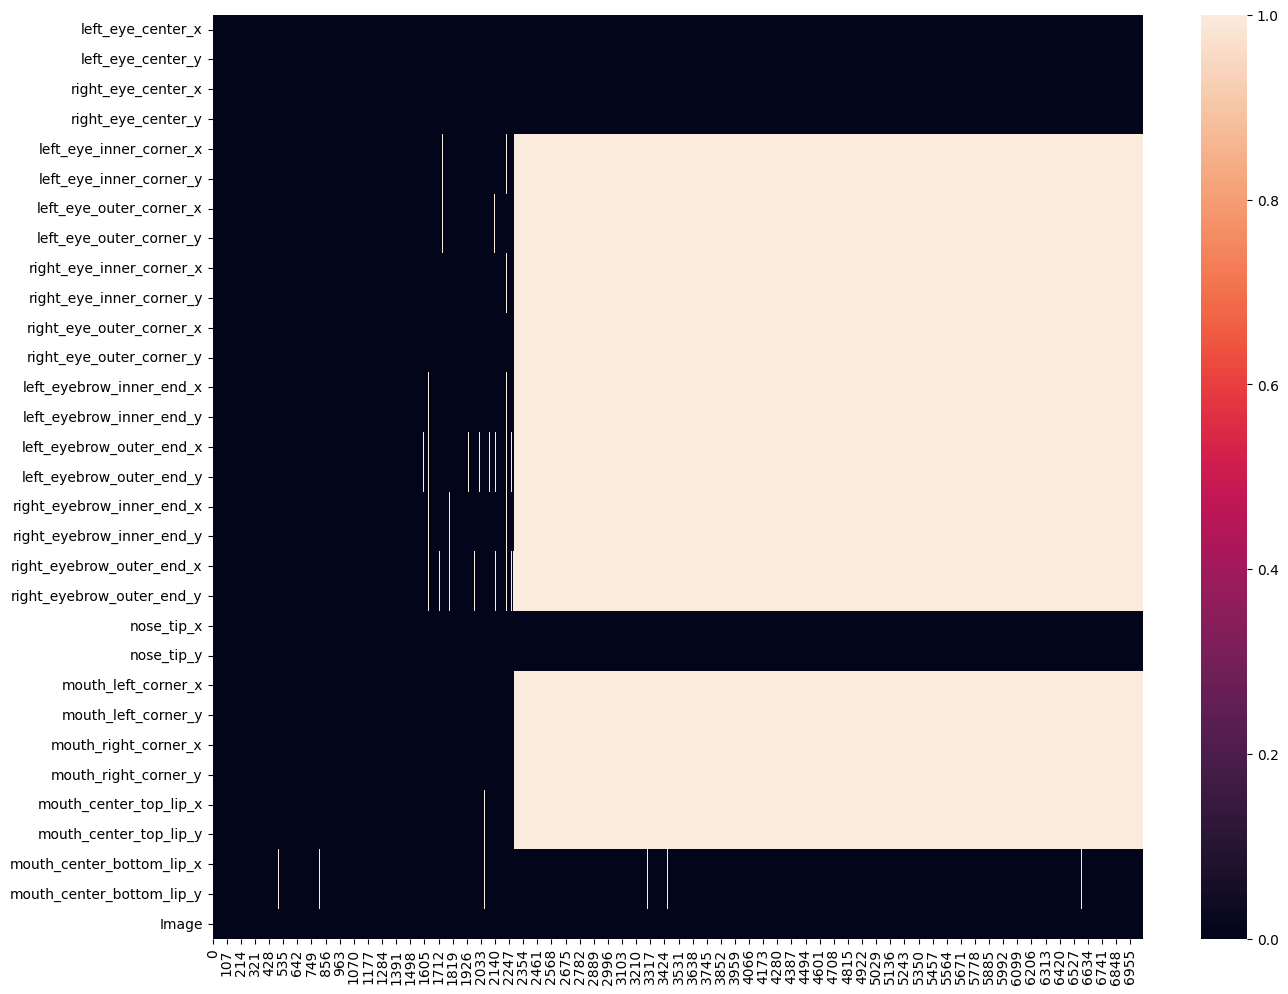

In [10]:
plt.subplots(figsize=(15,12))
sns.heatmap(train_csv.isna().T)

In [11]:
def get_num_images_complete_keypoints():
    image_counter = 0
    indices = []
    
    for idx, row in train_csv.iterrows():
        image_data = train_csv.iloc[idx]
        keypoints_data = image_data[:-1]
        
        # Check for non-numeric values and NaN
        valid_keypoint_data = keypoints_data[pd.to_numeric(keypoints_data, errors='coerce').notna()]
#         print(valid_keypoint_data)

        # Count the number of valid values
        num_valid_keypoint_data = len(valid_keypoint_data)
        
        if num_valid_keypoint_data == 30:
            image_counter += 1
            indices.append(idx)
            
    return image_counter, indices

In [12]:
def visualize_images_statistics(num_images_complete_keypoints: int, num_images_incomplete_keypoints: int):
    # Extract keypoint names and corresponding counts
    names = ["Images with complete keypoints", "Images with incomplete keypoints"]
    images_counts = [num_images_complete_keypoints, num_images_incomplete_keypoints]

    # Create a list of colors for neighboring bars
    bar_colors = ['blue' if i % 2 == 0 else 'orange' for i in range(len(names))]

    # Create a histogram with alternating colors for neighboring bars
    plt.figure(figsize=(5, 6))
    bars = plt.bar(names, images_counts, color=bar_colors)
    plt.ylabel('Number of Images')
#     plt.title('Number of Valid Values for Each Keypoint') # TODO
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    
    # Annotate each bar with its value
    for bar, count in zip(bars, images_counts):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.05, bar.get_height() + 0.3, str(count), ha='center', color='black')

    # Show the plot
    plt.show()

In [13]:
num_images_complete_keypoints = get_num_images_complete_keypoints()[0]
num_images_incomplete_keypoints = len(train_csv) - num_images_complete_keypoints

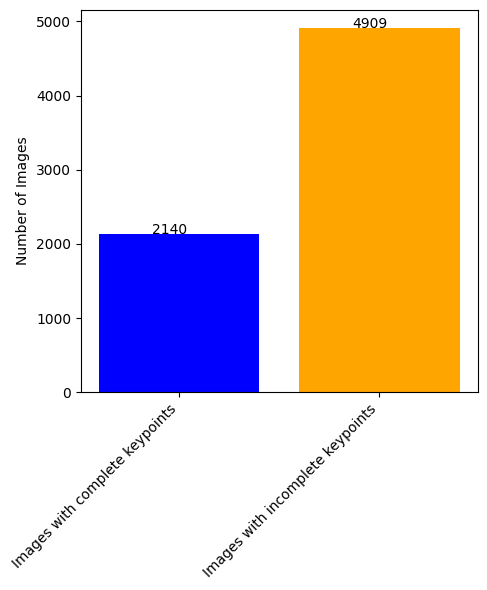

In [14]:
visualize_images_statistics(num_images_complete_keypoints, num_images_incomplete_keypoints)

## Dealing with lack of keypoints

In [15]:
def get_images_indices_lack_of_keypoints():
    images_indices = [] # list in which will be the indices of images with lack of keypoints
    
    for idx, row in train_csv.iterrows():
        image_data = train_csv.iloc[idx]
        keypoints_data = image_data[:-1]
        
        # Check for non-numeric values and NaN
        valid_keypoint_data = keypoints_data[pd.to_numeric(keypoints_data, errors='coerce').notna()]
        
        # Count the number of valid values
        num_valid_keypoint_data = len(valid_keypoint_data)
        
        if num_valid_keypoint_data < 30:
            images_indices.append(idx)
            
    return images_indices

In [16]:
images_list = get_images_indices_lack_of_keypoints()
# print(images_list)

Text(0.5, 0.98, 'Several images with incomplete keypoints')

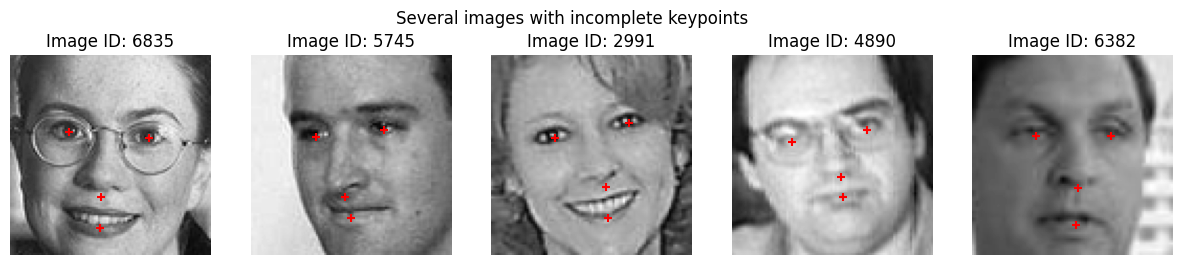

In [17]:
num_images = 5 # number of images to be visualized with keypoints
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
incomplete_keypoints_indices = []

for i in range(num_images):
    idx = random.randint(0,len(images_list)) # getting index for images_list
    image_idx = images_list[idx] # getting index of the image
    incomplete_keypoints_indices.append(image_idx)
    visualize_image_data(num_images, train_csv, image_idx, axes)
    
fig.suptitle("Several images with incomplete keypoints")

In [18]:
def get_mean_value_keypoints(train_csv: pd):
    keypoints_dict = {}
    
    for keypoint_name in train_csv.columns:
        if keypoint_name == "Image":
            continue
        
        keypoint_data = train_csv[keypoint_name]

        # Check for non-numeric values and NaN
        valid_keypoint_data = keypoint_data[pd.to_numeric(keypoint_data, errors='coerce').notna()]
        
        # Mean of valid keypoint data         
#         valid_keypoint_data_median = np.median(valid_keypoint_data)
        valid_keypoint_data_mean = np.mean(valid_keypoint_data) 
#         print(valid_keypoint_data_mean)
             
        keypoints_dict[keypoint_name] = valid_keypoint_data_mean
        
    return keypoints_dict

In [19]:
keypoints_mean_value_dict = get_mean_value_keypoints(train_csv)
keypoints_mean_value_dict

{'left_eye_center_x': 66.35902124475366,
 'left_eye_center_y': 37.65123419193395,
 'right_eye_center_x': 30.30610151407975,
 'right_eye_center_y': 37.97694257172698,
 'left_eye_inner_corner_x': 59.15933943740389,
 'left_eye_inner_corner_y': 37.94475232796772,
 'left_eye_outer_corner_x': 73.3304779831461,
 'left_eye_outer_corner_y': 37.707008310792986,
 'right_eye_inner_corner_x': 36.65260694805725,
 'right_eye_inner_corner_y': 37.98990191451049,
 'right_eye_outer_corner_x': 22.384504479169355,
 'right_eye_outer_corner_y': 38.03349517525053,
 'left_eyebrow_inner_end_x': 56.06851307930929,
 'left_eyebrow_inner_end_y': 29.332678249311716,
 'left_eyebrow_outer_end_x': 79.4828258641995,
 'left_eyebrow_outer_end_y': 29.734860732432317,
 'right_eyebrow_inner_end_x': 39.32213692201748,
 'right_eyebrow_inner_end_y': 29.502998474112996,
 'right_eyebrow_outer_end_x': 15.871177472719149,
 'right_eyebrow_outer_end_y': 30.428165911873432,
 'nose_tip_x': 48.37418629032876,
 'nose_tip_y': 62.715883597

In [20]:
# Now we will subsitute NaN values with mean value of each keypoint
def add_keypoints(train_csv: pd, keypoints_mean_value: dict):
    complete_training_data = train_csv.copy()
    
    for keypoint_name in complete_training_data.columns:
        if keypoint_name == "Image":
            continue
    
        mean_value = keypoints_mean_value[keypoint_name]
        complete_training_data[keypoint_name] = complete_training_data[keypoint_name].fillna(mean_value)
        
    return complete_training_data 

In [21]:
def knn_interpolation_dataframe(data: pd, k: int):
    data = data.copy()
    images_column = data["Image"]
    keypoints_names = []
    
    for keypoint_name in data.columns:
        if keypoint_name == "Image":
            continue
        keypoints_names.append(keypoint_name)
            
    data_without_img_column = data.drop(columns="Image")
    data_numpy = data_without_img_column.to_numpy()
#     print(data_numpy)
    imputer = KNNImputer(n_neighbors=k)
    res_KNN_data = imputer.fit_transform(data_numpy)
#     print(res_KNN)

    columns = keypoints_names
    rows = range(0, len(data))
    
    data_interpolated = pd.DataFrame(res_KNN_data, columns=columns, index=rows)
    data_interpolated["Image"] = images_column 
    
    return data_interpolated

In [22]:
print(len(train_csv))

7049


### Injecting keypoints

In [23]:
new_training_data_mean = add_keypoints(train_csv, keypoints_mean_value_dict)
new_training_data_interpolation = knn_interpolation_dataframe(train_csv, k=5)

Text(0.5, 0.98, 'Several images with added keypoints using mean value')

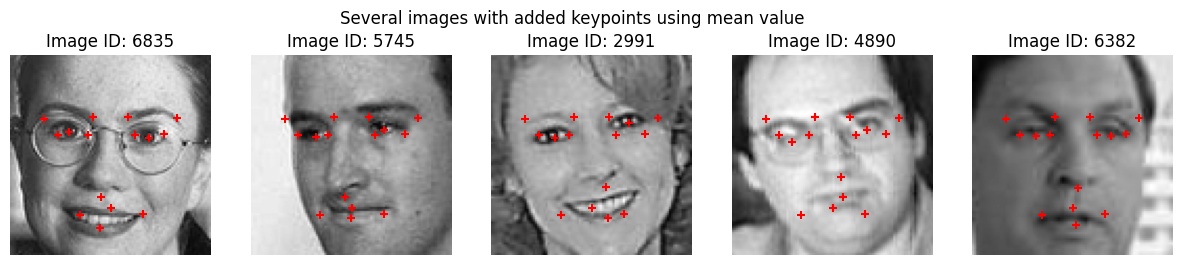

In [24]:
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i in range(num_images):
    image_idx = incomplete_keypoints_indices[i]
    visualize_image_data(num_images, new_training_data_mean, image_idx, axes)
    
fig.suptitle("Several images with added keypoints using mean value")

Text(0.5, 0.98, 'Several images with added keypoints using KNN interpolation')

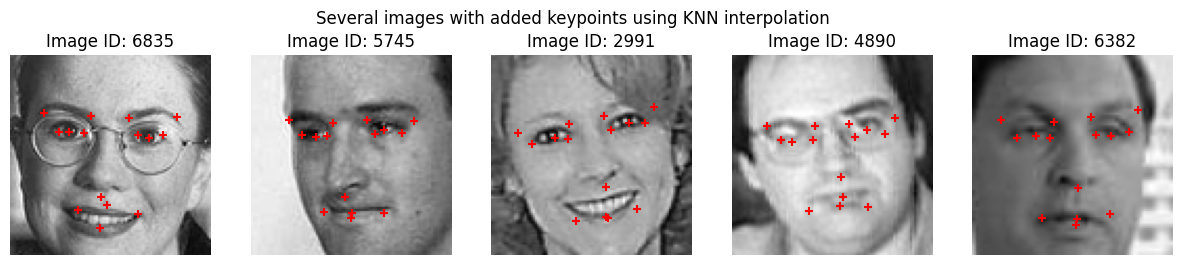

In [25]:
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i in range(num_images):
    image_idx = incomplete_keypoints_indices[i]
    visualize_image_data(num_images, new_training_data_interpolation, image_idx, axes)
    
fig.suptitle("Several images with added keypoints using KNN interpolation")

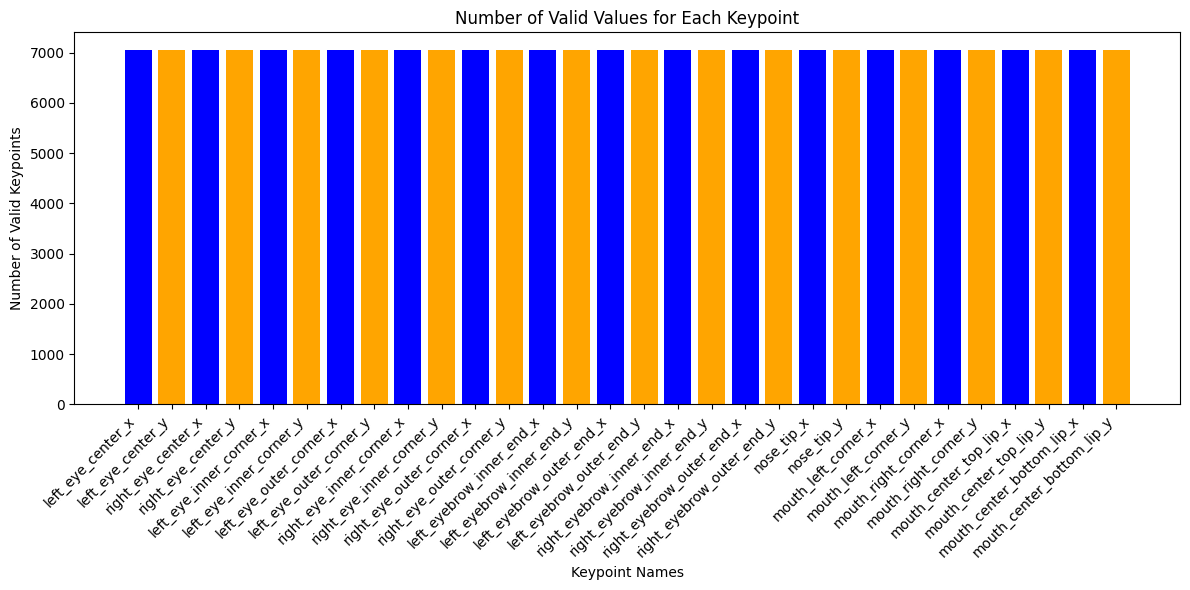

Number of x and y keypoints coordinates: 30.


In [26]:
keypoint_count_dictionary = get_keypoint_count_dictionary(new_training_data_mean)
visualize_num_valid_keypoints(keypoint_count_dictionary)
print(f"Number of x and y keypoints coordinates: {len(keypoint_count_dictionary)}.")

## Dataset

In [27]:
class FaceKeypointsDataset(Dataset):
    def __init__(self, img_data_frame: pd.DataFrame, keypoints_data_frame: pd.DataFrame, train=True, transform=None):
        self.img_data_frame = img_data_frame
        self.keypoints_data_frame = keypoints_data_frame
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.img_data_frame)

    def __getitem__(self, idx):
        if self.train:
            image_data = self.img_data_frame.iloc[idx]
            keypoints = np.array(self.keypoints_data_frame.iloc[idx], dtype=np.float32)
        else:
            image_data = self.img_data_frame.iloc[idx]
            keypoints = None

        image_values = np.array(image_data.split(), dtype=np.uint8)
        image = image_values.reshape((96, 96, 1))

        sample = {'image': image, 
                  'keypoints': keypoints}

        if self.transform:
            sample = self.transform(sample)

        return sample

### Augmentations

In [28]:
# transform = A.Compose([
#     A.GaussianBlur (blur_limit=(3, 7)),
#     A.Normalize(mean=(0.5,), std=(0.5,)), 
#     ToTensorV2(),
# ])

### Preparing dataset

In [29]:
# Parameters
batch_size = 64 # number of samples for training
num_workers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split train dataset into 2 parts (train set + validation set)
# Specify the features (X) and target variable (y)
X = new_training_data_interpolation['Image'] # Images
y = new_training_data_interpolation.drop('Image', axis=1)  # Keypoints

# Split the data into training and validation sets (80 % training set + 20 % validation set)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)

print(type(X_train))

X_train shape: (5639,)
X_valid shape: (1410,)
y_train shape: (5639, 30)
y_valid shape: (1410, 30)
<class 'pandas.core.series.Series'>


In [30]:
# Getting train and validation datasets
train_dataset = FaceKeypointsDataset(
    img_data_frame=X_train,
    keypoints_data_frame=y_train,
    train=True,
    transform=None
)

val_dataset = FaceKeypointsDataset(
    img_data_frame=X_valid,
    keypoints_data_frame=y_valid,
    train=True, # TODO
    transform=None
)

[126 128 141 ... 186 187 187]


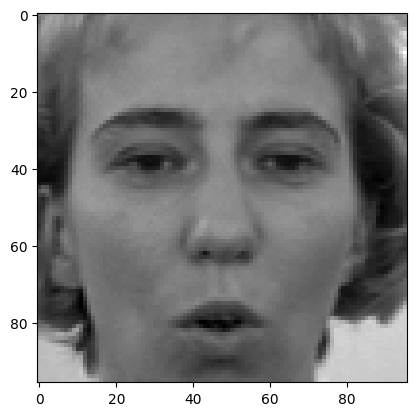

In [31]:
test = np.array(X_train.iloc[idx].split(), dtype=np.uint8)
print(test)
plt.imshow(test.reshape(96,96), cmap="gray")
plt.show()

### Dataloader

In [32]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True, 
)


val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

loaders = {'train': train_loader, 'val': val_loader}

# print(len(X_train))
# print(len(y_train))
# print(len(X_val))
# print(len(y_val))

### Dataset size

In [33]:
print(f"Train set size: {len(train_loader.dataset)} images.")
print(f"Validation set size: {len(val_loader.dataset)} images.\n")

print(f"Dataset size: {np.sum([len(train_loader.dataset), len(val_loader.dataset)])} images.")

Train set size: 5639 images.
Validation set size: 1410 images.

Dataset size: 7049 images.


In [34]:
print(train_loader.dataset)

## Visualizing training data

from train_loader

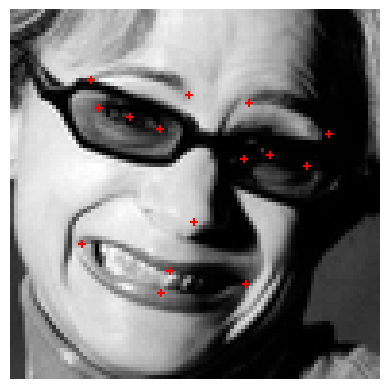

In [35]:
def show_image_loader(loader, idx):
    dataiter = iter(loader)
    batch = next(dataiter)

    # Extract the first image and keypoints from the batch
    image = batch['image'][idx]
    keypoints = batch['keypoints'][idx] if 'keypoints' in batch else None

    # Display the image
    plt.imshow(image, cmap="gray")
    
    # Plot keypoints on the image if available
    if keypoints is not None:
        for i in range(0, len(keypoints), 2):
            x, y = keypoints[i], keypoints[i + 1]
            plt.scatter(x, y, color='red', marker='+')

    plt.axis('off')
    plt.show()

# Assuming you have a DataLoader named 'train_loader'
show_image_loader(train_loader, idx=0)

## Usage of a pretrained model

In [36]:
from torchvision import models

In [37]:
dir(models) # available models and weights from torchvision

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

### W&B setup

In [38]:
# W&B login
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: janburian. Use `wandb login --relogin` to force relogin


True

In [39]:
def create_actual_timestamp():
    current_time = datetime.now()
    time_string = current_time.strftime("%Y%m%d%H%M%S")
    
    return time_string

In [40]:
# Initialize W&B
wandb.init( # set the wandb project where this run will be logged
    project = "facial_keypoints_detection",
#     name = "test", # TODO

    # track hyperparameters and run metadata
    config = {
        "learning_rate": 1e-4,
        "batch_size": batch_size, 
        "architecture": "Resnet50 model",
        "dataset": "Facial keypoints detection",
        "num_epochs": 100,
        "dropout": 0.7,
        "device": device,
        "timestamp": create_actual_timestamp(),
    }
)


# Copy config
config = wandb.config

### Model initialization

In [41]:
class FacialKeypointsDetectionModel(nn.Module):
    def __init__(self, num_keypoints, dropout_prob):
        super(FacialKeypointsDetectionModel, self).__init__()
        
        # Load a pretrained ResNet model
        self.pretrained_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept 1 channel (grayscale)
        self.pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the final fully connected layer to match the number of classes in your dataset
        in_features = self.pretrained_model.fc.in_features
#         self.pretrained_model.fc = nn.Linear(in_features, num_classes)
        self.pretrained_model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
#             nn.Sigmoid(),
#             nn.Dropout(p=dropout_prob),  # Add dropout
            nn.Linear(512, num_keypoints)
        )

    def forward(self, x):
        return self.pretrained_model(x)

In [42]:
def train_regression_model(train_loader, val_loader, num_epochs, learning_rate, model):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

    for epoch in range(num_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch_idx, sample in enumerate(train_loader):
            x = sample['image'].permute(0, 3, 1, 2).float().to(device)
#             x = sample['image'].to(device)
            y = sample['keypoints'].to(device)
            pred = model(x)

            # calculate the loss
            loss = criterion(pred, y)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            train_loss += loss.item()

        model.eval()  # prep model for evaluation
        with torch.no_grad():
            all_pred_val = []
            all_y_val = []

            for batch_idx, sample in enumerate(val_loader):
                x_val = sample['image'].permute(0, 3, 2, 1).float().to(device)
                y_val = sample['keypoints'].to(device)
                pred_val = model(x_val)

                all_pred_val.append(pred_val)
                all_y_val.append(y_val)

            # Concatenate predictions and targets for the entire validation set
            all_pred_val = torch.cat(all_pred_val, dim=0)
            all_y_val = torch.cat(all_y_val, dim=0)

            # Calculate the loss for the entire validation set
            loss = criterion(all_pred_val, all_y_val)

            valid_loss += loss.item()
        
        mse = nn.MSELoss()(all_pred_val, all_y_val).item()

        avg_valid_loss = valid_loss / len(val_loader)
        avg_train_loss = train_loss / len(train_loader)
        
        wandb.log({
            "Train Loss": avg_train_loss,
            "Validation Loss": avg_valid_loss,
            "MSE": mse,
        }, step=epoch + 1)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.6f}, "
              f"Validation Loss: {avg_valid_loss:.6f}, "
              f"MSE: {mse:.6f}")
        
    print('Training finished.')
    return model

In [43]:
num_keypoints = 30
dropout = config["dropout"]
model = FacialKeypointsDetectionModel(num_keypoints, dropout).to(device)
trained_model = train_regression_model(train_loader, val_loader, config["num_epochs"], learning_rate=config["learning_rate"], model=model)

Epoch [1/100], Train Loss: 1253.935069, Validation Loss: 0.871582, MSE: 20.046394
Epoch [2/100], Train Loss: 12.074075, Validation Loss: 1.034756, MSE: 23.799393
Epoch [3/100], Train Loss: 10.849828, Validation Loss: 0.808095, MSE: 18.586182
Epoch [4/100], Train Loss: 10.174787, Validation Loss: 0.890438, MSE: 20.480085
Epoch [5/100], Train Loss: 10.043612, Validation Loss: 0.691974, MSE: 15.915410
Epoch [6/100], Train Loss: 9.587781, Validation Loss: 0.840205, MSE: 19.324724
Epoch [7/100], Train Loss: 9.278988, Validation Loss: 0.844751, MSE: 19.429272
Epoch [8/100], Train Loss: 9.128893, Validation Loss: 0.735738, MSE: 16.921970
Epoch [9/100], Train Loss: 8.931981, Validation Loss: 0.676370, MSE: 15.556505
Epoch [10/100], Train Loss: 8.797204, Validation Loss: 0.780932, MSE: 17.961435
Epoch [11/100], Train Loss: 8.450505, Validation Loss: 0.834831, MSE: 19.201111
Epoch [12/100], Train Loss: 8.318157, Validation Loss: 0.730267, MSE: 16.796152
Epoch [13/100], Train Loss: 7.884642, Vali

### Saving trained model

In [59]:
trained_models_directory = Path('./trained_models/facial_keypoints_models/')
output_directory = os.path.join(os.getcwd(), trained_models_directory)
print(os.path.exists(output_directory))
torch.save(trained_model.state_dict(), os.path.join(output_directory, "model_resnet_50.pth_" + create_actual_timestamp()))

True


## Test data

In [60]:
test_data_path = os.path.join(BASE_directory, "test", "test.csv")
test_data = pd.read_csv(test_data_path)

In [61]:
test_data

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
...,...,...
1778,1779,101 101 101 100 100 97 97 98 102 149 214 206 1...
1779,1780,201 191 171 158 145 140 136 130 123 115 108 10...
1780,1781,28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...
1781,1782,104 95 71 57 46 52 65 70 70 67 76 72 69 69 72 ...


In [62]:
test_data_images = test_data['Image'] # Images

test_dataset = FaceKeypointsDataset(
    img_data_frame=test_data_images,
    keypoints_data_frame=None,
    train=False,
    transform=None
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

In [63]:
print(test_loader.dataset[0])

{'image': array([[[182],
        [183],
        [182],
        ...,
        [182],
        [182],
        [182]],

       [[182],
        [181],
        [181],
        ...,
        [182],
        [182],
        [182]],

       [[182],
        [181],
        [180],
        ...,
        [182],
        [181],
        [182]],

       ...,

       [[ 42],
        [ 36],
        [ 20],
        ...,
        [126],
        [136],
        [153]],

       [[ 31],
        [  8],
        [  0],
        ...,
        [  9],
        [ 11],
        [ 33]],

       [[  3],
        [  0],
        [  1],
        ...,
        [  8],
        [  5],
        [  5]]], dtype=uint8), 'keypoints': None}


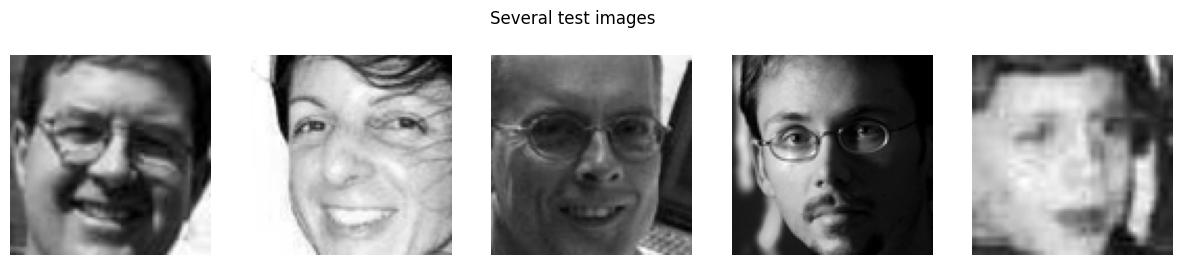

In [64]:
num_images = 5  # number of test images to be visualized
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    idx = random.randint(0, len(test_loader.dataset) - 1)  # Ensure the index is within the dataset size
    test_image = test_loader.dataset[idx]["image"]
    axes[i].imshow(test_image, cmap="gray")
    axes[i].axis('off')  # Turn off axis for cleaner visualization

fig.suptitle("Several test images")
plt.show()

In [65]:
test_images_list = []

for i in range(len(test_loader.dataset)):
    test_image = test_loader.dataset[i]["image"]
    test_images_list.append(test_image)
    
test_images_list = np.array(test_images_list)

In [66]:
test_images_tensor = torch.tensor(test_images_list, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

trained_model.eval()
with torch.no_grad():
    predicted_keypoints = trained_model(test_images_tensor)

predicted_keypoints = predicted_keypoints.cpu() 

In [67]:
print(predicted_keypoints[0].tolist())

[65.15940856933594, 37.22948455810547, 29.26483917236328, 36.46077346801758, 59.76814651489258, 37.21307373046875, 71.97679138183594, 37.39457702636719, 35.91830825805664, 37.31770324707031, 23.228723526000977, 37.392635345458984, 57.3712272644043, 25.882768630981445, 77.97059631347656, 26.77570152282715, 36.720428466796875, 26.169960021972656, 16.587779998779297, 27.385635375976562, 49.12628173828125, 51.009464263916016, 63.143253326416016, 75.17018127441406, 34.69281768798828, 75.5199203491211, 48.73983383178711, 68.29564666748047, 48.88582992553711, 83.18134307861328]


### Test data visualisation

In [68]:
# Function to plot image with keypoints
def plot_image_with_predicted_keypoints(ax, img: np.array, keypoints, idx):
    # Plot the image
    ax.imshow(img, cmap='gray')

    # Plot keypoints and lines with text annotations
    for i in range(0, len(keypoints), 2):
        x, y = keypoints[i], keypoints[i + 1]

        # Plot keypoint
        ax.scatter(x, y, color='red', marker='+')

#         # Connect keypoint with a line
#         ax.plot([x, x], [y, y], color='blue', linestyle='--')

#         # Add text label at the end of the line
#         label = f"({x}, {y})"
#         ax.text(x, y, label, color='blue', fontsize=8, ha='right', va='bottom')

    ax.set_title(f"Image ID: {idx}")
    ax.axis('off')
    
def visualize_image_with_pred_keypoints(number_of_images, test_images: list, pred_keypoints, idx: int, axes):
    image = test_images[idx]
    keypoints = pred_keypoints[idx].tolist()
    plot_image_with_predicted_keypoints(axes[i], image, keypoints, idx)

Text(0.5, 0.98, 'Test images with predicted keypoints')

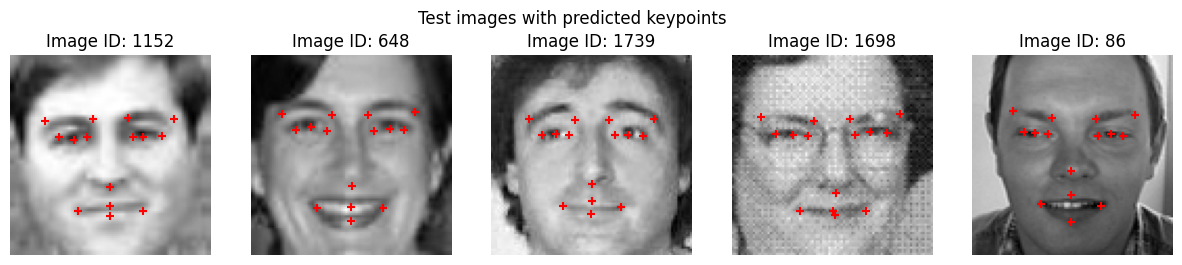

In [69]:
num_images = 5 # number of images to be visualized with predicted keypoints
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    idx = random.randint(0,len(test_images_list))
    visualize_image_with_pred_keypoints(num_images, test_images_list, predicted_keypoints, idx, axes)
fig.suptitle("Test images with predicted keypoints")

### Creating submission .csv file

In [70]:
# Loading .csv files
SampleSubmission_path = os.path.join(BASE_directory, "SampleSubmission.csv")
idLookup_path = os.path.join(BASE_directory, "IdLookupTable.csv")


# Convert to pandas dataframe
SampleSubmission = pd.read_csv(SampleSubmission_path)
idLookup = pd.read_csv(idLookup_path)

# Submission output path
submission_output_path = os.path.join(os.getcwd(), "output", "submission_keypoints.csv")

In [71]:
SampleSubmission.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [72]:
idLookup.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [73]:
feature = list(idLookup['FeatureName'])
image_ids = list(idLookup['ImageId']-1)
row_ids = idLookup['RowId']

predicted_keypoints_list = predicted_keypoints.tolist()

feature_list = [feature.index(f) for f in feature]

final_predictions = [float(predicted_keypoints_list[x][y]) for x, y in zip(image_ids, feature_list)]

row_ids = pd.Series(row_ids, name='RowId')
locations = pd.Series(final_predictions, name='Location').clip(0.0, 96.0)

submission_result = pd.concat([row_ids, locations], axis=1)

submission_result.to_csv(submission_output_path, index=False)